# Choose a Car Profitably [Car Price prediction] PART.2

This work has made by Paul Krivchenia in cooperation with Vitaliy Burlakov (a.k.a Vetak8):
#### [My GitHub](https://github.com/Paull-dark)
#### [Vetak's GitHub](https://github.com/vetak8)
#### [Vetak's Kaggle](https://www.kaggle.com/vitaliyburlakov)

<img src = 'http://3.bp.blogspot.com/--knDCWYzMOw/UqzpwyctJeI/AAAAAAAAAT8/Ui66KNd1nXM/s1600/7egylh57hbhs.jpg' width= '400px'>

<a id="sec2"></a>
# [INDEX](#sec2)

<a id="sec1"></a>
1. [Description](#sec1)
   * [1.1 Features Defination](#sec1.1)
2. [INDEX](#sec2)
3. [IMPORT LIBRARRIES](#sec3)
4. [Functions and Classes](#sec4)
5. [Load and Chek the Dataset](#sec5)

<a id="sec2"></a>
# [Import LIBRARIES](#sec2)

In [122]:
from Preprocessing import df_combined

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from jupyterthemes import jtplot

from textblob import TextBlob  # for sentiment analysis
from wordcloud import WordCloud  # for creating cloud of words
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRFRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm  as lgb
import lightgbm
import optuna


from xgboost import plot_importance

warnings.filterwarnings("ignore")

%matplotlib inline
pd.set_option('display.max_rows', 50)  # Show more rows
pd.set_option('display.max_columns', 50)  # Show more columns
plt.style.use('ggplot')  # Nice plotting

jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

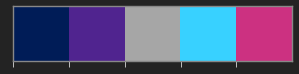

In [2]:
# Set project colors
colors = ['#001c57', '#50248f', '#a6a6a6', '#38d1ff','#cc3181']
sns.palplot(sns.color_palette(colors))

<a id="sec4"></a>
# [FUNCTIONS and CLASSES](#sec4)
[(INDEX)](#sec2)

<a id="sec4"></a>
## [GENERAL FUNCTIONS](#sec4)
[(INDEX)](#sec2)

In [3]:
def missing_vars(data, column, random_proba=True):
    '''Function is called for filling of missing data'''
    # With using probability and random choise

    if random_proba:
        col_name = data[column].value_counts().index.to_list(
        )  # get list of values
        col_distr = data[column].value_counts(
            normalize=True).values  # get l;ist of probs
        missing = data[col].isnull()  # flag of missing val
        # substitute values from the list of names in accordance with the probability of meeting the name
        data.loc[missing, [column]] = np.random.choice(col_name,
                                                    size=len(data[missing]),
                                                    p=col_distr)

    # Using  most common in  column
    data[col] = data[col].fillna(data[col].value_counts().index[0])

In [4]:
def get_variable_distribution(col, title=None):
    '''Function is called to plot feture distribution'''

    title = title if title is not None else f"Distribution for '{col}"
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5),)
    fig = sm.qqplot(col, fit=True, line='45', ax=ax1)
    fig.suptitle(title, fontsize=20)

    sns.distplot(col.values, bins=20, color=colors[1], ax=ax2)
#     sns.violinplot(col.values, color=colors[3], bw=.3, cut=1, linewidth=4)
    sns.boxplot(col.values,color=colors[3])

    ax1.set_title('QQ-plot')
    ax2.set_title('Distribution')
    ax3.set_title('Boxplot')

    plt.show()

In [5]:
def corr_matrix(data, det=True, pltx=10, plty=10):
    '''Funcion is called for making correlation matrix'''

    corr = data.corr()
    if det:

        evals, evec = np.linalg.eig(corr)
        ev_product = np.prod(evals)

        print(f'Rank of Matrix: {np.linalg.matrix_rank(corr)}')
        print(f'Determinant of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(corr)}')

    plt.figure(figsize=(pltx, plty))
    sns.heatmap(corr[(corr >= .2) | (corr <= -.2)],
                cmap='viridis',
                vmin=-1.0,
                linewidths=0.1,
                annot=True,
                annot_kws={"size": 10},
                square=True)
    #     sns.heatmap(X,vmin=0,vmax=.9,annot=True,square=True)
    plt.show()

In [6]:
def cleanTxt(text):
    '''Function is called for cleaning text from trash
    INPUT: dirty string
    OUTPUT: More or less clean string'''

    text = re.sub(r'@[А-Яа-я0-9]+', '', text)  # Remove @
    text = re.sub(r'#', '', text)  # remove #
    text = re.sub(r'{', '', text)
    text = re.sub(r'}', '', text)
    text = re.sub('^а-яА-Я', ' ', text)
    text = re.sub(r'https?:\/\/\S+', '', text)  # remove hyperlink
    text = re.sub(r'\n', '', text)
    text = re.sub(r'👍🏻', '', text)
    # there are much more emoji. I don't know how to identify them so far

    text = text.lower()
    text = text.strip()
    #text = text.split()
    return text

In [7]:
def to_log(df, cols_to_log):
    for col in cols_to_log:
        a = df[col].min()
        if a <= 0:                        
            df[col] = np.log(df[col] + (int(abs(df[col].min()))+2))
        
        df[col] = np.log(df[col])
    return df

In [8]:
# Defining MAPE function since it was removed from sklearn
def mape(y_true, y_pred): 
#     y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

In [76]:
def get_regression_metrics(report_df,y_true, y_pred, name):
    '''Create and add metrics into a pandas DF after experiment'''
    y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)

    report = pd.DataFrame(columns={'MAPE'}, data=[0])
    try:
        report['MAPE'] = mape(y_true, y_pred)
    except:
        report['MAPE'] = 'failed'
    report['MAE'] = mean_absolute_error(y_true, y_pred)
    report['MSE'] = mean_squared_error(y_true, y_pred)
    report['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

<a id="sec4"></a>
## [Classes](#sec4)
[(INDEX)](#sec2)

In [11]:
class Encoder():
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def label_encoder(self, column):
        le = LabelEncoder()
        self.dataframe[column] = le.fit_transform(self.dataframe[column])

    def hot_encoder(self, column):
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        aux_df = pd.DataFrame(ohe.fit_transform(self.dataframe[[column]]))
        aux_df.columns = ohe.get_feature_names([f'hot_{column}'])
        self.dataframe = self.dataframe.drop(col, axis=1)
        self.dataframe = pd.concat([self.dataframe, aux_df], axis=1)
        return self.dataframe

In [12]:
class Outliers_detector():
    def __init__(self, df):
        self.df = df

    def get_IQR_outliers(self, column):
        '''Method is called to detect IQR outliers'''
        outliers = dict()
        q1, q3 = np.percentile(sorted(self.df[column]), [25, 75])

        IQR = q3 - q1

        l_b = q1 - (1.5 * IQR)  # lower bound
        u_b = q3 + (1.5 * IQR)  # upper bound
        outl_count = len(self.df[column][self.df[column] < l_b]) + len(
            self.df[column][self.df[column] > u_b])

        outliers['lower_bound'] = round(l_b, 3)
        outliers['upper_bound'] = round(u_b, 3)
        outliers['outlier_count'] = outl_count

        return outliers

    def get_dbscan_outliers(self, column1, column2, dbscan_eps,
                            dbscan_minsample, cluster_num):
        '''Method is called for detecting outliers for two columns by dbscan'''

        scaler = RobustScaler()
        scale_column1 = scaler.fit_transform(pd.DataFrame(
            self.df[column1])).reshape(1, -1)[0]
        scale_column2 = scaler.fit_transform(pd.DataFrame(
            self.df[column2])).reshape(1, -1)[0]
        df_temp = pd.DataFrame({
            'column1': scale_column1,
            'column2': scale_column2
        })
        clustering = DBSCAN(eps=dbscan_eps,
                            min_samples=dbscan_minsample).fit(df_temp.values)
        df_temp["cluster"] = clustering.labels_
        df_temp.index = self.df.index
        fig = px.scatter(self.df,
                   x=scale_column1,
                   y=scale_column2,
                   color=clustering.labels_,
                   size=column2)
        # Edit the layout
        fig.update_layout(title='Detected Custers\n')
        fig.update_xaxes(title=(f'{column1}'))
        fig.update_yaxes(title=(f'{column2}'))
        fig.update_layout(width = 700)
        fig.update_layout(height = 600)
        
        fig.show()
        #         sns.scatterplot(scale_column1, scale_column2,
        #                         hue=clustering.labels_, alpha=0.5)
        #         plt.title('CLUSTERS\n', fontsize=15)
        #         plt.xlabel(f'{column1}')
        #         plt.ylabel(f'{column2}')
        return df_temp[df_temp["cluster"] == cluster_num].index

<a id="sec4"></a>
## [FUNCTIONS FOR FEATURE ENGINEERING](#sec4)
[(INDEX)](#sec2)

In [13]:
def get_tax_category(engine_power):
    '''Function breaks down the number of horse
    power by taxation category in Russia'''

    if engine_power <= 100:
        return int(1)
    elif 100 < engine_power <= 150:
        return int(2)
    elif 150 < engine_power <= 200:
        return int(3)
    elif 200 < engine_power <= 250:
        return int(4)
    elif engine_power > 250:
        return int(5)


def get_low_registr(word):
    '''Get lowercase for string'''
    try:
        return word.lower()
    except:
        return None
    
def get_i3_displacement(engine_displacement, fuel_type, model_name):
    '''fill mising values for  BMW i3'''
    
    if model_name == 'i3':
        if fuel_type == 'гибрид':
            return 0.7
        else:
            return 0
    else:
        return engine_displacement

def get_electro_displacement(engine_displacement, fuel_type):
    '''Filling mising vars for electrocars'''
    
    if fuel_type == 'электро':
        return 0
    else:
        return engine_displacement
    
def get_acceleration(string):
    '''Function extracting acceleration'''
    
    try:
        return float(re.split(',', re.split('acceleration\W+', str(string))[1])[0])
    except:
        return None
    
def get_fuel_rate(string):
    '''Extrating fuel rate'''
    try:
        return float(re.split(',', re.split('fuel_rate\W+', str(string))[1])[0])

    except:
        return None

<a id="sec5"></a>
# [5.Load and Chek the Dataset](#sec5)
[(INDEX)](#sec2)

In [14]:
# import data pre-processed data set
df = df_combined.copy()
df.sample(2)

body_type       brand  color  \
61119     универсал 5 дв      Nissan  белый   
116527  внедорожник 5 дв  Mitsubishi  белый   

                                       complectation_dict  \
61119                                         {'id': '0'}   
116527  {'id': '22745323', 'name': 'Instyle', 'availab...   

                                              description  \
61119   25 ПТС, ДВС контрактный, в ПТС стоит отметка н...   
116527  «Mitsubishi КЛЮЧАВТО Люберцы» — официальный ди...   

        engine_displacement  engine_power  \
61119                   1.8         125.0   
116527                  2.0         150.0   

                                           equipment_dict fuel_type  \
61119                   {'computer': True, 'alarm': True}    бензин   
116527  {'cruise-control': True, 'asr': True, 'tinted-...    бензин   

                                                    image  mileage  \
61119   //avatars.mds.yandex.net/get-autoru-vos/452026...   160000   
116527  //avatars.mds.yandex.net/get-autoru-vos/218133...        0   

        model_date                                         model_info  \
61119         1999  {'code': 'EXPERT', 'name': 'Expert', 'ru_name'...   
116527        2020  {'code': 'ECLIPSE_CROSS', 'name': 'Eclipse Cro...   

           model_name                name  doors_count price_currency  \
61119          EXPERT   1.8 AT (125 л.с.)            5            RUB   
116527  ECLIPSE_CROSS  2.0 CVT (150 л.с.)            5            RUB   

        production_date     sell_id  \
61119              2000  1103497230   
116527             2021  1103635536   

                                                super_gen  \
61119   {'id': '9382506', 'displacement': 1769, 'engin...   
116527  {'id': '22745140', 'displacement': 1998, 'engi...   

       vehicle_configuration vehicle_transmission    vendor owner_count  \
61119            useless_col            AUTOMATIC  JAPANESE           3   
116527           useless_col             VARIATOR  JAPANESE         NaN   

                     owning_period car_passport wheel_drive wheel_location  \
61119   {'year': 2011, 'month': 5}     ORIGINAL    передний          RIGHT   
116527                         NaN     ORIGINAL    передний           LEFT   

       condition custom      price  sample  
61119       True   True   190000.0       1  
116527      True   True  2753000.0       1

<a id="sec6"></a>
# [9.FETAURE ENGINEERING](#sec6)
[(INDEX)](#sec2)

Get lowercase

In [15]:
# take cols with objects
object_columns = df.dtypes[df.dtypes.values == object].index.to_list()

for col in object_columns:
    df[col] = df[col].apply(lambda string: get_low_registr(string))

<a id="sec6"></a>
## [Target](#sec6)
[(INDEX)](#sec2)

Drop rows with car price more than 30 mlns.

In [16]:
idx_to_drop = list(df[df['price'] >= 30000000].index)
df=df.drop(idx_to_drop)

Drop rows with missing values

In [17]:
df.query('sample == 1')['price'].isna().sum()

624

In [18]:
indexes_to_drop = df[(df['price'].isna()) & (df['sample']==1)].index
df = df.drop(indexes_to_drop)

<a id="sec6"></a>
## [body_type](#sec6)
[(INDEX)](#sec2)

Reduce quantity of body_types

In [19]:
pattern = re.compile('[а-я]*')
new_column = []
for string in df['body_type']:
    new_column.append(pattern.match(str(string))[0])
df['body_type'] = new_column

In [20]:
# Create list with top colors
top_colors = df['body_type'].value_counts()[df['body_type'].value_counts(
) > np.percentile((df['body_type'].value_counts().values), 70)].index.tolist()

#take all colors from df to a list
all_colors = df['body_type'].value_counts().index

# Identify, what to delete
colors_to_drop = set(all_colors) - set(top_colors)

# Make replacemewnt
df.loc[df['body_type'].isin(colors_to_drop), 'body_type'] = 'other'

In [21]:
df['body_type'].value_counts()

седан          66648
внедорожник    63983
хэтчбек        16791
other          14990
лифтбек         9291
универсал       7030
Name: body_type, dtype: int64

In [22]:
body_type_dict = dict({
    'седан':'sedan',
    'внедорожник':'4wd',
    'хэтчбек':'hachtback',
    'other':'other',
    'лифтбек':'liftback',
    'универсал':'universal'
})
df['body_type'] = df['body_type'].map(body_type_dict)

In [23]:
df.body_type.unique()

array(['liftback', '4wd', 'hachtback', 'sedan', 'other', 'universal'],
      dtype=object)

<a id="sec6"></a>
## [color](#sec6)
[(INDEX)](#sec2)

With a reference to EDA section we generate new feature to show whether the color is popular.

Meanwhile we re-orgasnize colors in original column by taking only most common colors

In [24]:
# List of top3 colors (see EDA)
popular_color = ['чёрный', 'белый', 'серый']
df['popular_color'] = df['color'].apply(
    lambda color: 1 if color in popular_color else 0)

In [25]:
# Create list with top colors
top_colors = df['color'].value_counts()[df['color'].value_counts(
) > np.percentile((df['color'].value_counts().values), 70)].index.tolist()

#take all colors from df to a list
all_colors = df['color'].value_counts().index

# Identify, what to delete
colors_to_drop = set(all_colors) - set(top_colors)

# Make replacemewnt
df.loc[df['color'].isin(colors_to_drop), 'color'] = 'other'

In [26]:
color_dict = dict({
    'синий':'blue',
    'чёрный':'black',
    'серый':'gray',
    'other':'other',
    'белый':'white',
    'серебристый':'silver'
})
df['color'] = df['color'].map(color_dict)

<a id="sec6"></a>
## [Model_name](#sec6)
[(INDEX)](#sec2)

<a id="sec6"></a>
## [Description](#sec6)
[(INDEX)](#sec2)

Let's generate new features:
- Sensitivity and polarity for the description column

In [27]:
df['description'] = df['description'].fillna('none')
df['description'] = df['description'].apply(cleanTxt)

In [28]:
# Create a function to get the subjectivity
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [29]:
# %%script false
# Create new cols and call the func

df['subjectivity'] = df['description'].apply(get_subjectivity)

df['polarity'] = df['description'].apply(get_polarity)


In [30]:
# Create a function to compute the negative, neutral and positive analysis
def get_analysis(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

In [31]:
# %%script false
df['analysis'] = df['polarity'].apply(get_analysis)

In [32]:
# show data
df.sample(4)

body_type       brand  color  \
154467       4wd         kia  other   
140775       4wd       lexus   gray   
36497      sedan         bmw  other   
26093      sedan  volkswagen  other   

                                       complectation_dict  \
154467  {'id': '20967626', 'name': 'comfort', 'availab...   
140775  {'id': '21476573', 'name': 'black vision', 'av...   
36497                                         {'id': '0'}   
26093                                                None   

                                              description  \
154467  автомобиль представлен гк автопремиум, официал...   
140775  цена с выгодой действительна при условии сдачи...   
36497                             все вопросы по телефону   
26093   продаю родной vw passat cc 2.0 tsi в практичес...   

        engine_displacement  engine_power  \
154467                  2.4         175.0   
140775                  2.0         150.0   
36497                   2.5         192.0   
26093                   2.0         210.0   

                                           equipment_dict fuel_type  \
154467  {'cruise-control': true, 'asr': true, 'tinted-...    бензин   
140775  {'cruise-control': true, 'asr': true, 'esp': t...    бензин   
36497                                                  {}    бензин   
26093   {"engine-proof":true,"tinted-glass":true,"esp"...    бензин   

                                                    image  mileage  \
154467  //avatars.mds.yandex.net/get-autoru-vos/440293...   115000   
140775  //avatars.mds.yandex.net/get-autoru-vos/444184...        0   
36497                                                None   360000   
26093   https://avatars.mds.yandex.net/get-autoru-vos/...   154000   

        model_date                                         model_info  \
154467        2012  {'code': 'sorento', 'name': 'sorento', 'ru_nam...   
140775        2017  {'code': 'nx', 'name': 'nx', 'ru_name': 'н-икс...   
36497         2000  {'code': '5er', 'name': '5 серии', 'ru_name': ...   
26093         2012  {"code":"passat_cc","name":"passat cc","ru_nam...   

       model_name                        name  doors_count price_currency  \
154467    sorento       2.4 at (175 л.с.) 4wd            5            rub   
140775         nx  200 2.0 cvt (150 л.с.) 4wd            5            rub   
36497         5er      525i 2.5 at (192 л.с.)            4            rub   
26093   passat_cc          2.0 amt (210 л.с.)            4            rub   

        production_date     sell_id  \
154467             2016  1103378937   
140775             2021  1103238794   
36497              2000  1102897966   
26093              2012  1101299575   

                                                super_gen  \
154467  {'id': '8506343', 'displacement': 2359, 'engin...   
140775  {'id': '21131144', 'name': '200', 'nameplate':...   
36497   {'id': '6329845', 'name': '525', 'nameplate': ...   
26093   {"id":"7813130","displacement":1984,"engine_ty...   

       vehicle_configuration vehicle_transmission    vendor owner_count  \
154467           useless_col            automatic    korean           1   
140775           useless_col             variator  japanese         NaN   
36497            useless_col            automatic  european           3   
26093        sedan robot 2.0                robot  european           3   

           owning_period car_passport wheel_drive wheel_location  \
154467              None     original      полный           left   
140775              None     original      полный           left   
36497               None     original      задний           left   
26093   3 года и 1 месяц     original    передний           left   

                 condition      custom      price  sample  popular_color  \
154467                None        None  1519000.0       1              0   
140775                None        None  3318000.0       1              1   
36497                 None        None   400000.0       1          

<a id="sec6"></a>
## [fuel_type](#sec6)
[(INDEX)](#sec2)

In [33]:
# lets strip fuel type
df['fuel_type'] = df.fuel_type.apply(lambda fuel: str(fuel).strip())

In [34]:
fuel_type_dict = dict({
    'бензин':'benzin',
    'дизель':'dizel',
    'гибрид':'hybrid',
    'электро':'electro',
    'газ':'gas'
})

df['fuel_type'] = df['fuel_type'].map(fuel_type_dict)

<a id="sec6"></a>
## [engine_displacement](#sec6)
[(INDEX)](#sec2)

We know, that there is no engine displacement for the electical cars. We also know there is missing values in this colums.

Let's fix it. If car is electric - diplacement shall be 0.

In [35]:
df['engine_displacement'] = df[['engine_displacement','fuel_type']].apply(
    lambda x: get_electro_displacement(*x), axis=1)

It was observed that BMW model i3 has missing values in engine displacement. Let's say if it it is hybrid - then eng_displ - 0.7. If n0 - then 0

In [36]:
df['engine_displacement'] = df[['engine_displacement','fuel_type', 'model_name']].apply(
    lambda x: get_i3_displacement(*x), axis=1)

<a id="sec6"></a>
## [engine_power](#sec6)
[(INDEX)](#sec2)

There is a special low in Russian Federation that devide cars by tax categories. 

More power in engine, higer grade of tax. It may impact on a prediction. Let's break our cars down by such categories

In [37]:
df['tax_rate'] = df['engine_power'].apply(
    lambda engine_power: get_tax_category(engine_power)).astype('category')

<a id="sec6"></a>
## [Super_gen](#sec6)
[(INDEX)](#sec2)

Let's extract some information like an acceleration from supergen column.

Generated new feature Acceleration

In [38]:
# Before we do, fill up empty dictionaries with 'Nan'
df['super_gen'] = df['super_gen'].fillna('NaN')
df['super_gen'] = df['super_gen'].apply(cleanTxt)
# Extract fuel rate,acceleration and generate new feature
df['acceleration'] = df['super_gen'].apply(lambda string:get_acceleration(string))
df['fuel_rate'] = df['super_gen'].apply(lambda string:get_fuel_rate(string))

In [39]:
# missing vars in a new feature
df['acceleration'].isna().sum()

11243

In [40]:
df['fuel_rate'].isna().sum()

21408

Let's fill missing values by randomly choosen value from most common in particular colums.

For a company, add car pasport here and owner count

In [41]:
cols_to_fill = ['acceleration', 'fuel_rate', 'car_passport','owner_count']
for col in cols_to_fill:
    missing_vars(df,col)

<a id="sec6"></a>
## [Wheel drive](#sec6)
[(INDEX)](#sec2)

In [42]:
# lets strip fuel type
df['wheel_drive'] = df.wheel_drive.apply(lambda drive: str(drive).strip())

In [43]:
df['wheel_drive'].unique()

array(['передний', 'полный', 'задний', 'None'], dtype=object)

In [44]:
drive_type_dict = dict({
    'передний':'benzin',
    'полный':'dizel',
    'задний':'hybrid',
    
})

df['wheel_drive'] = df['wheel_drive'].map(drive_type_dict)

<a id="sec6"></a>
## [Price change index ](#sec6)
[(INDEX)](#sec2)

With a reference to EDA, we know, that some brands loose their price more faster than others. Let's generate such feature

In [45]:
def get_change_index(model):
    if model == 'ford':
        return int(1)
    if model == 'volvo' or model == 'mercedes-benz':
        return int(2)
    if model == 'honda' or model == 'audi':
        return int(2)
    return int(0)

In [46]:
df['prc_chg_idx'] = df['brand'].apply(
    lambda brand: get_change_index(brand)).astype('category')

<a id="sec6"></a>
## [Dropping cars without info out](#sec6)
[(INDEX)](#sec2)

In [47]:
df['engine_displacement'].isna().sum()

49

In [48]:
df = df.dropna(axis=0, subset=['engine_displacement'])

<a id="sec6"></a>
## [Handling multicollinearity out](#sec6)
[(INDEX)](#sec2)

In [49]:
# extract trhee columns from dataset, which are correlated
data = df[['mileage', 'model_date','production_date']].values
# create Scaler instance
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# We have 3 vectors. Reduce to two, taking most important info.
pca = PCA(n_components=2)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
df['pca_1'],df['pca_2'] = pca_data[:,0],pca_data[:,1]
# df = df.drop(['model_date','mileage'],axis=1)

<a id="sec6"></a>
## [Clustering](#sec6)
[(INDEX)](#sec2)

In [50]:
cluster = Outliers_detector(df)

In [51]:
# indeces = cluster.get_dbscan_outliers('model_date', 'mileage', dbscan_eps=.3,
#                                      dbscan_minsample=12,
#                                      cluster_num=-1)
# print(f"Strange guys {len(indeces)}")

<a id="sec6"></a>
## [Logarithm](#sec6)
[(INDEX)](#sec2)

In [52]:
cols_to_log = [
    'engine_displacement',
    'production_date',
    'pca_1', 'pca_2',
    'engine_power',
    'mileage',
    'model_date',
    'acceleration',
    'fuel_rate',
]

df = to_log(df, cols_to_log)

<a id="sec6"></a>
## [ENCODING](#sec6)
[(INDEX)](#sec2)

In [53]:
# Re-set indeces
df.reset_index(drop=True, inplace=True)

In [54]:
# Save un-encoded df
df_cat = df.copy()

In [55]:
encoder = Encoder(df)

In [56]:
to_hot = [
    'body_type',
    'brand',
    'color',
    'fuel_type',    
    'doors_count',
    'vehicle_transmission',
    'vendor',
    'wheel_drive',
    'tax_rate',
    'analysis',
    'owner_count',
    ]

to_label = ['car_passport', 'wheel_location','prc_chg_idx']

In [57]:
#%%script false
for col in to_hot:
    df = encoder.hot_encoder(col)

In [58]:
for col in to_label:
    encoder.label_encoder(col)

<a id="sec6"></a>
## [DROP COLS OUT](#sec6)
[(INDEX)](#sec2)

In [59]:
cols_to_drop = [
    'complectation_dict',
    'description',
    'equipment_dict',
    'image',
    'model_info',
    'name',
    'price_currency',
    'vehicle_configuration',
    'custom',
    'condition',
    'owning_period',
    'super_gen', 'sell_id',
    'model_name',
    'engine_power',
    'mileage', # have PCA instead
    'model_date', # have PCA instead
    'production_date' # have PCA instead
]
df = df.drop(cols_to_drop, axis=1)

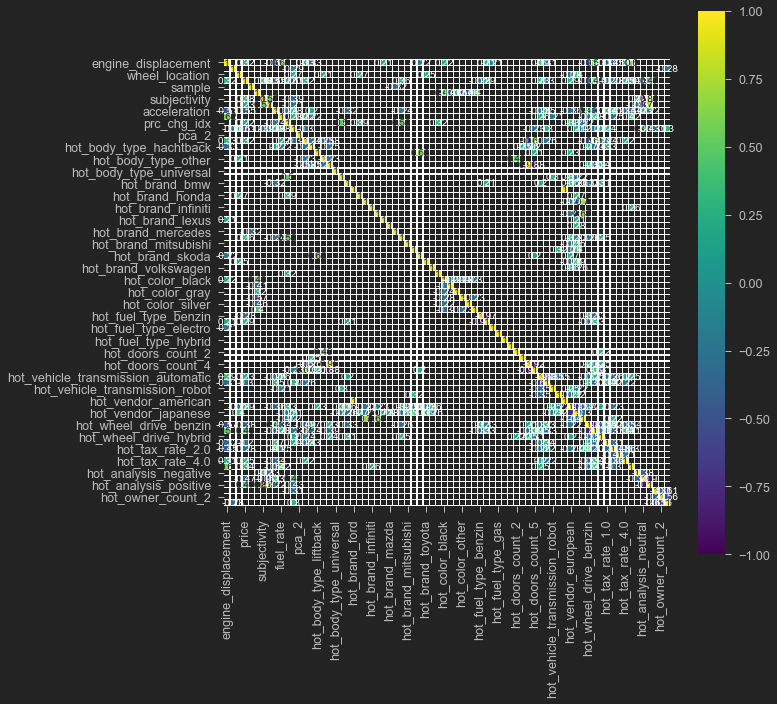

In [60]:
corr_matrix(df, det=False)

engine_displacement - 0%
car_passport - 0%
wheel_location - 0%
price - 19%
sample - 0%
popular_color - 0%
subjectivity - 0%
polarity - 0%
acceleration - 0%
fuel_rate - 0%
prc_chg_idx - 0%
pca_1 - 0%
pca_2 - 0%
hot_body_type_4wd - 0%
hot_body_type_hachtback - 0%
hot_body_type_liftback - 0%
hot_body_type_other - 0%
hot_body_type_sedan - 0%
hot_body_type_universal - 0%
hot_brand_audi - 0%
hot_brand_bmw - 0%
hot_brand_ford - 0%
hot_brand_honda - 0%
hot_brand_hyundai - 0%
hot_brand_infiniti - 0%
hot_brand_kia - 0%
hot_brand_lexus - 0%
hot_brand_mazda - 0%
hot_brand_mercedes - 0%
hot_brand_mercedes-benz - 0%
hot_brand_mitsubishi - 0%
hot_brand_nissan - 0%
hot_brand_skoda - 0%
hot_brand_toyota - 0%
hot_brand_volkswagen - 0%
hot_brand_volvo - 0%
hot_color_black - 0%
hot_color_blue - 0%
hot_color_gray - 0%
hot_color_other - 0%
hot_color_silver - 0%
hot_color_white - 0%
hot_fuel_type_benzin - 0%
hot_fuel_type_dizel - 0%
hot_fuel_type_electro - 0%
hot_fuel_type_gas - 0%
hot_fuel_type_hybrid - 0%


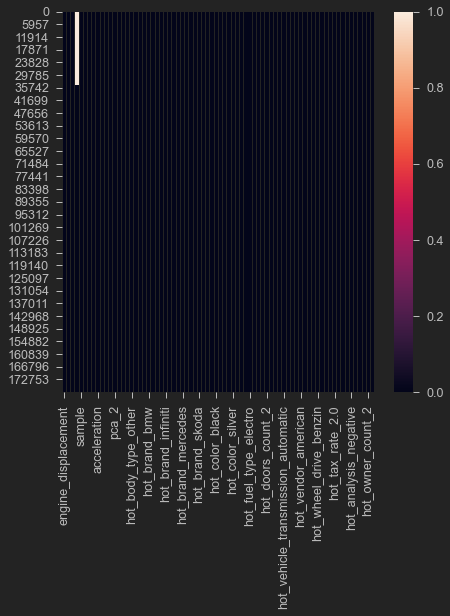

In [61]:
# Plot missing values
cols = df.columns
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(df[cols].isnull()) 

# Show in percents
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print(f'{col} - {round(pct_missing*100)}%')

<a id="sec6"></a>
## [Scaling](#sec6)
[(INDEX)](#sec2)

In [62]:
# # Extract the part of dataframe for testing
# df_train = df.query('sample == 1').drop(['sample'], axis=1)
# df_valid = df.query('sample == 0').drop(['sample'], axis=1)

# # Extract data and label
# X = df_train.drop(['price'], axis=1)
# y = df_train[['price']]

# # Extract data for validation
# X_valid = df_valid.drop(['price'], axis=1)

In [63]:
# cols_to_scal = [
#     'engine_displacement', 'subjectivity', 
#     'polarity', 'acceleration',
#     'fuel_rate', 'pca_1', 'pca_2'
# ]

In [64]:
# scaler = RobustScaler()
# X[cols_to_scal] = scaler.fit_transform(X[cols_to_scal])
# X_valid[cols_to_scal] = scaler.transform(X_valid[cols_to_scal])

In [65]:
# print(
#     f'Shape of X_train:{X.shape} \nShape of X_Valid:{X_valid.shape} \nShape of Target:{y.shape} '
# )

<a id="sec6"></a>
# [9.Models](#sec6)
[(INDEX)](#sec2)

In [66]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, shuffle=True, random_state=42)

In [67]:
# from lazypredict.Supervised import LazyRegressor

In [68]:
# %%script false
# reg = LazyRegressor(verbose=1, ignore_warnings=False, custom_metric=None)

In [69]:
# %%script false
# models,predictions = reg.fit(X_train, X_test, y_train, y_test)

In [70]:
# %%script false
# models

<a id="sec6"></a>
## [EXTRA-TREE](#sec6)
[(INDEX)](#sec2)

In [71]:
# def mape(y_true, y_pred): 
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

In [72]:
# Defining features and target
X = df[df['sample'] == 1].drop('price', axis=1)
y = np.log(df[df['sample'] == 1]['price'])

# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  shuffle=True, random_state=42)
X_test = df[df['sample'] == 0].drop(['price'], axis=1)
y_test = df[df['sample'] == 0]['price']
print(f'Train size: {X_train.shape}, Validation size: {X_val.shape}, Test size: {X_test.shape}')

Train size: (115235, 73), Validation size: (28809, 73), Test size: (34640, 73)


<a id="sec6"></a>
## [EXTRA-TREE](#sec6)
[(INDEX)](#sec2)

In [73]:
# Training and evaluating Random Forest
rf = ExtraTreesRegressor(n_estimators=300, random_state=42, n_jobs=-1,
                         bootstrap=True, verbose=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

# MAPE = mape(np.exp(y_val), np.exp(y_pred))
# print(f'Mean Absolute Percentage Error: {MAPE}')

In [74]:
df_report = pd.DataFrame(data=None)

In [77]:
df_report = get_regression_metrics(df_report,y_val,y_pred, 'ExtraTree+baseline')
df_report

MAPE            MAE           MSE           RMSE
ExtraTree+baseline  16.485389  133171.400375  1.156922e+11  340135.584512

<a id="sec6"></a>
## [CAT_boost](#sec6)
[(INDEX)](#sec2)

In [ ]:
# # Training the model
# cbr = CatBoostRegressor()

# # Grid search for catboost model
# param_grid = {'iterations': [500],
#               'learning_rate': [0.01, 0.1, 0.25, 0.5],
#               'l2_leaf_reg': [1, 3, 5, 10],
#               'depth': np.arange(10, 14),
#               'thread_count': [4]}

# cbr.grid_search(param_grid=param_grid,
#                 X=X,
#                 y=y,
#                 cv=5,
#                 partition_random_seed=42,
#                 calc_cv_statistics=True,
#                 search_by_train_test_split=True,
#                 refit=True,
#                 shuffle=True,
#                 stratified=None,
#                 train_size=0.8,
#                 verbose=True,
#                 plot=True)

In [ ]:
# grid_search = GridSearchCV(cbr, param_grid, n_jobs=-1,
#                            scoring=mape, cv=5, refit=True,
#                            return_train_score=True, verbose=5)

# grid_search.fit(X, y)

In [ ]:
# Best model parameters
# cbr.get_params()

In [ ]:
# mape(np.exp(y_val), np.exp(cbr.predict(X_val)))

# XGBoost

In [78]:
# Training xgboost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=1000, silent=1)
xg_reg.fit(X_train, y_train)
xg_red_pred = xg_reg.predict(X_val)

[14:20:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [ ]:
# MAPE for XGBoost
# mape(np.exp(y_val), np.exp(xg_red_pred))

In [ ]:
# # Cross-validation for XGBoost
# params = {'objective': 'reg:squarederror',
#           'colsample_bytree': 0.5,
#           'learning_rate': 0.05,
#           'max_depth': 10, 
#           'alpha': 1,
#           'n_estimators': 1000}

# cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
#                     num_boost_round=1000, early_stopping_rounds=10,
#                     metrics="rmse", as_pandas=True, seed=0)

In [79]:
df_report = get_regression_metrics(df_report,y_val,xg_red_pred, 'XGBoost_1')
df_report

MAPE            MAE           MSE           RMSE
ExtraTree+baseline  16.485389  133171.400375  1.156922e+11  340135.584512
XGBoost_1           16.267781  133636.793979  1.096894e+11  331193.915468

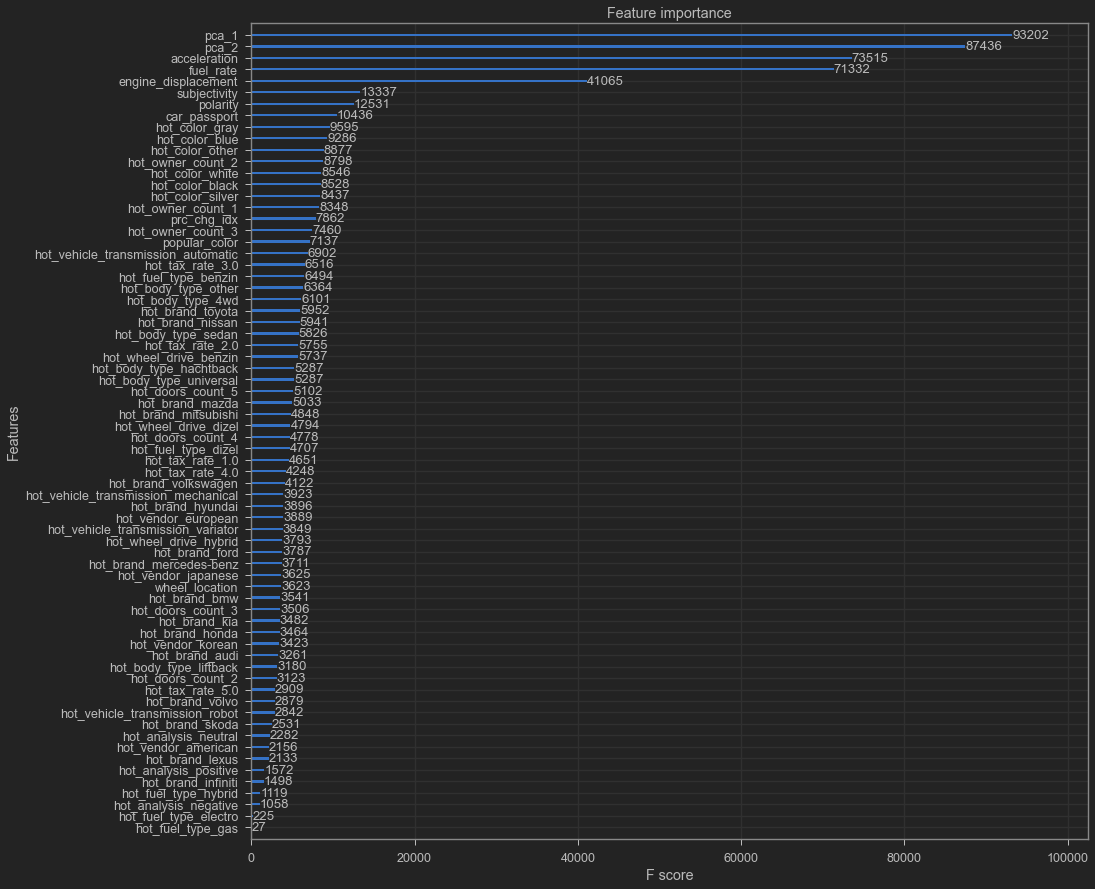

In [80]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(xg_reg,ax=ax)

In [81]:
ddd = ['hot_fuel_type_gas','hot_fuel_type_electro','hot_analysis_negative',
      'hot_fuel_type_hybrid','hot_brand_infiniti','hot_analysis_positive',
      'hot_vendor_american','hot_brand_lexus','hot_analysis_neutral',
      'hot_brand_skoda','hot_vehicle_transmission_robot','hot_tax_rate_5.0',
      'hot_brand_volvo','hot_doors_count_2','hot_body_type_liftback',
      'hot_brand_audi','hot_brand_honda','wheel_location','hot_vendor_korean',
      'hot_brand_bmw','hot_brand_kia','hot_vendor_japanese',]

In [ ]:
# X_train.columns

In [82]:
X_train_red = X_train.drop(ddd, axis=1)
X_val_red = X_val.drop(ddd, axis=1)

In [83]:
# Training xgboost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=1000, silent=1)
xg_reg.fit(X_train_red, y_train)
xg_red_pred = xg_reg.predict(X_val_red)

[14:25:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [84]:
df_report = get_regression_metrics(df_report,y_val,xg_red_pred, 'XGBoost_reduced_features')
df_report

MAPE            MAE           MSE  \
ExtraTree+baseline        16.485389  133171.400375  1.156922e+11   
XGBoost_1                 16.267781  133636.793979  1.096894e+11   
XGBoost_reduced_features  16.321725  134068.711963  1.112268e+11   

                                   RMSE  
ExtraTree+baseline        340135.584512  
XGBoost_1                 331193.915468  
XGBoost_reduced_features  333506.759386

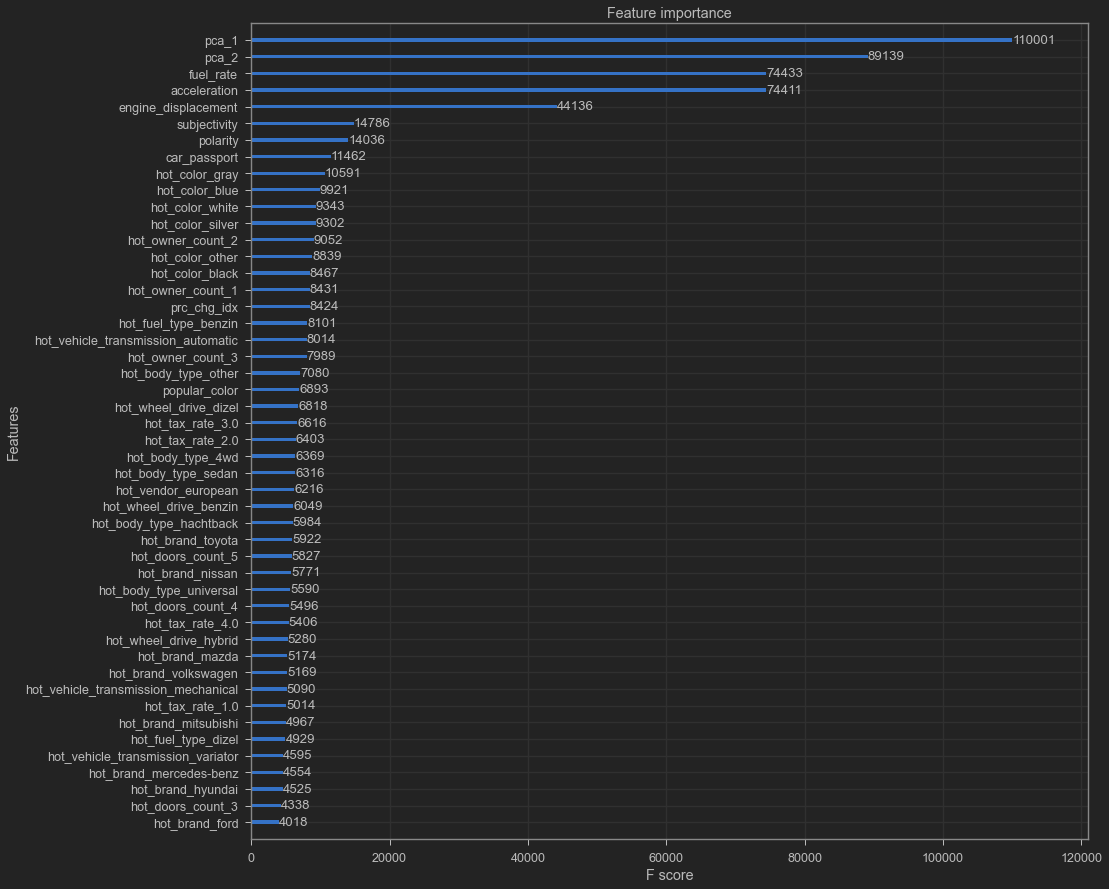

In [85]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(xg_reg,ax=ax)

## OPTUNA

In [108]:
def objective(trial, data=X, target=y):

    train_x, test_x, train_y, test_y = train_test_split(
        data, target, test_size=0.15, random_state=42)
    param = {
        # this parameter means using the GPU when training our model to speedup the training process
        'tree_method': "exact",#'gpu_hist',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.009, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]),
        'n_estimators': trial.suggest_categorical('n_estimators', [100,200,400,800,1000,1500]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15, 17, 20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48, 2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)

    model.fit(train_x, train_y, eval_set=[
              (test_x, test_y)], early_stopping_rounds=100, verbose=False)

    preds = model.predict(test_x)

    rmse = mean_squared_error(test_y, preds, squared=False)

    return rmse

In [109]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-05-27 14:52:45,757] A new study created in memory with name: no-name-9248caa9-2a71-4390-a541-3a3c2834bf6e
[I 2021-05-27 14:55:56,155] Trial 0 finished with value: 0.27242195273502073 and parameters: {'lambda': 0.2845340980269337, 'alpha': 4.275252563933468, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008, 'n_estimators': 1000, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 239}. Best is trial 0 with value: 0.27242195273502073.
[I 2021-05-27 14:57:58,335] Trial 1 finished with value: 0.25259476510335344 and parameters: {'lambda': 0.004107815055849089, 'alpha': 0.01981593885313598, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.02, 'n_estimators': 400, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 4}. Best is trial 1 with value: 0.25259476510335344.
[I 2021-05-27 15:06:58,446] Trial 2 finished with value: 0.24883189550137963 and parameters: {'lambda': 0.005911489104331869, 'alpha': 0.097900208995578, 'colsample_bytree': 1.

[I 2021-05-27 16:21:43,407] Trial 22 finished with value: 0.2526503338807642 and parameters: {'lambda': 0.2403761133389355, 'alpha': 0.001178543778202051, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.012, 'n_estimators': 1500, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 68}. Best is trial 7 with value: 0.24843220852625422.


KeyboardInterrupt: 

In [ ]:
param_xb = study.best_params

In [110]:
reg_xb = xgb.XGBClassifier(param = param_xb)

reg_xb.fit(X_train, y_train)
reg_xb_pred = reg_xb.predict(X_val)

# LGBM

In [92]:
# Defining lightgbm hyper-parameters
hyper_params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': ['mape'],
                'learning_rate': 0.05,
                'feature_fraction': 0.9,
                'bagging_fraction': 0.7,
                'bagging_freq': 10,
                'verbose': 0,
                "max_depth": 12,
                "num_leaves": 128,  
                "max_bin": 512,
                "num_iterations": 1000,
                "n_estimators": 1000
            }

# Training lightgbm model
lgbm = lgb.LGBMRegressor(**hyper_params)
lgbm.fit(X_train, y_train,
         eval_set=[(X_val, y_val)],
         eval_metric='l1',
         early_stopping_rounds=100)

# Printing the result
# mape(np.exp(y_val), np.exp(lgbm.predict(X_val)))


[1]	valid_0's l1: 0.908817	valid_0's mape: 0.0681056
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 0.866549	valid_0's mape: 0.0649559
[3]	valid_0's l1: 0.82651	valid_0's mape: 0.0619707
[4]	valid_0's l1: 0.788603	valid_0's mape: 0.0591459
[5]	valid_0's l1: 0.752673	valid_0's mape: 0.0564678
[6]	valid_0's l1: 0.718561	valid_0's mape: 0.0539245
[7]	valid_0's l1: 0.686281	valid_0's mape: 0.0515174
[8]	valid_0's l1: 0.655767	valid_0's mape: 0.0492411
[9]	valid_0's l1: 0.626803	valid_0's mape: 0.0470823
[10]	valid_0's l1: 0.599502	valid_0's mape: 0.0450479
[11]	valid_0's l1: 0.573666	valid_0's mape: 0.0431231
[12]	valid_0's l1: 0.549263	valid_0's mape: 0.0413032
[13]	valid_0's l1: 0.526114	valid_0's mape: 0.0395774
[14]	valid_0's l1: 0.504295	valid_0's mape: 0.0379502
[15]	valid_0's l1: 0.483651	valid_0's mape: 0.0364113
[16]	valid_0's l1: 0.464136	valid_0's mape: 0.0349559
[17]	valid_0's l1: 0.445664	valid_0's mape: 0.033579
[18]	valid_0's l1: 0.428328	val

[155]	valid_0's l1: 0.160551	valid_0's mape: 0.0124592
[156]	valid_0's l1: 0.160485	valid_0's mape: 0.0124544
[157]	valid_0's l1: 0.160466	valid_0's mape: 0.0124529
[158]	valid_0's l1: 0.160376	valid_0's mape: 0.0124466
[159]	valid_0's l1: 0.16026	valid_0's mape: 0.0124386
[160]	valid_0's l1: 0.160265	valid_0's mape: 0.0124391
[161]	valid_0's l1: 0.160184	valid_0's mape: 0.0124333
[162]	valid_0's l1: 0.1601	valid_0's mape: 0.0124275
[163]	valid_0's l1: 0.160042	valid_0's mape: 0.0124233
[164]	valid_0's l1: 0.159965	valid_0's mape: 0.0124175
[165]	valid_0's l1: 0.15991	valid_0's mape: 0.0124134
[166]	valid_0's l1: 0.159844	valid_0's mape: 0.0124088
[167]	valid_0's l1: 0.159788	valid_0's mape: 0.0124047
[168]	valid_0's l1: 0.159704	valid_0's mape: 0.0123988
[169]	valid_0's l1: 0.159611	valid_0's mape: 0.0123918
[170]	valid_0's l1: 0.159526	valid_0's mape: 0.0123856
[171]	valid_0's l1: 0.159487	valid_0's mape: 0.0123825
[172]	valid_0's l1: 0.159393	valid_0's mape: 0.0123759
[173]	valid_0'

[305]	valid_0's l1: 0.15675	valid_0's mape: 0.0121913
[306]	valid_0's l1: 0.156754	valid_0's mape: 0.0121916
[307]	valid_0's l1: 0.156753	valid_0's mape: 0.0121917
[308]	valid_0's l1: 0.156759	valid_0's mape: 0.0121923
[309]	valid_0's l1: 0.156786	valid_0's mape: 0.0121946
[310]	valid_0's l1: 0.156748	valid_0's mape: 0.012192
[311]	valid_0's l1: 0.156727	valid_0's mape: 0.0121903
[312]	valid_0's l1: 0.156701	valid_0's mape: 0.0121883
[313]	valid_0's l1: 0.156667	valid_0's mape: 0.0121858
[314]	valid_0's l1: 0.156644	valid_0's mape: 0.0121841
[315]	valid_0's l1: 0.156592	valid_0's mape: 0.0121802
[316]	valid_0's l1: 0.156564	valid_0's mape: 0.0121782
[317]	valid_0's l1: 0.156558	valid_0's mape: 0.0121779
[318]	valid_0's l1: 0.156538	valid_0's mape: 0.0121764
[319]	valid_0's l1: 0.15651	valid_0's mape: 0.0121745
[320]	valid_0's l1: 0.156499	valid_0's mape: 0.0121736
[321]	valid_0's l1: 0.15649	valid_0's mape: 0.0121729
[322]	valid_0's l1: 0.156448	valid_0's mape: 0.0121699
[323]	valid_0'

[456]	valid_0's l1: 0.155019	valid_0's mape: 0.0120737
[457]	valid_0's l1: 0.155017	valid_0's mape: 0.0120736
[458]	valid_0's l1: 0.15502	valid_0's mape: 0.012074
[459]	valid_0's l1: 0.155014	valid_0's mape: 0.0120735
[460]	valid_0's l1: 0.155011	valid_0's mape: 0.0120733
[461]	valid_0's l1: 0.154979	valid_0's mape: 0.0120709
[462]	valid_0's l1: 0.154963	valid_0's mape: 0.0120696
[463]	valid_0's l1: 0.154966	valid_0's mape: 0.0120699
[464]	valid_0's l1: 0.15496	valid_0's mape: 0.0120695
[465]	valid_0's l1: 0.154957	valid_0's mape: 0.0120694
[466]	valid_0's l1: 0.154942	valid_0's mape: 0.0120682
[467]	valid_0's l1: 0.154929	valid_0's mape: 0.0120673
[468]	valid_0's l1: 0.154925	valid_0's mape: 0.012067
[469]	valid_0's l1: 0.154926	valid_0's mape: 0.0120672
[470]	valid_0's l1: 0.154935	valid_0's mape: 0.0120677
[471]	valid_0's l1: 0.154924	valid_0's mape: 0.0120669
[472]	valid_0's l1: 0.154934	valid_0's mape: 0.0120676
[473]	valid_0's l1: 0.154933	valid_0's mape: 0.0120676
[474]	valid_0'

[605]	valid_0's l1: 0.154082	valid_0's mape: 0.0120106
[606]	valid_0's l1: 0.154071	valid_0's mape: 0.0120097
[607]	valid_0's l1: 0.154065	valid_0's mape: 0.0120092
[608]	valid_0's l1: 0.15405	valid_0's mape: 0.0120081
[609]	valid_0's l1: 0.154025	valid_0's mape: 0.0120062
[610]	valid_0's l1: 0.154021	valid_0's mape: 0.012006
[611]	valid_0's l1: 0.154013	valid_0's mape: 0.0120054
[612]	valid_0's l1: 0.154012	valid_0's mape: 0.0120052
[613]	valid_0's l1: 0.154014	valid_0's mape: 0.0120053
[614]	valid_0's l1: 0.154017	valid_0's mape: 0.0120057
[615]	valid_0's l1: 0.154008	valid_0's mape: 0.0120051
[616]	valid_0's l1: 0.154009	valid_0's mape: 0.0120052
[617]	valid_0's l1: 0.153997	valid_0's mape: 0.0120045
[618]	valid_0's l1: 0.154	valid_0's mape: 0.0120049
[619]	valid_0's l1: 0.153994	valid_0's mape: 0.0120044
[620]	valid_0's l1: 0.153985	valid_0's mape: 0.0120038
[621]	valid_0's l1: 0.153987	valid_0's mape: 0.0120038
[622]	valid_0's l1: 0.15399	valid_0's mape: 0.0120041
[623]	valid_0's 

[760]	valid_0's l1: 0.153863	valid_0's mape: 0.012001
[761]	valid_0's l1: 0.153873	valid_0's mape: 0.0120017
[762]	valid_0's l1: 0.153877	valid_0's mape: 0.012002
[763]	valid_0's l1: 0.153884	valid_0's mape: 0.0120025
[764]	valid_0's l1: 0.153871	valid_0's mape: 0.0120017
[765]	valid_0's l1: 0.153877	valid_0's mape: 0.0120022
[766]	valid_0's l1: 0.153874	valid_0's mape: 0.012002
[767]	valid_0's l1: 0.153873	valid_0's mape: 0.0120019
[768]	valid_0's l1: 0.15388	valid_0's mape: 0.0120024
[769]	valid_0's l1: 0.153872	valid_0's mape: 0.0120018
[770]	valid_0's l1: 0.153878	valid_0's mape: 0.0120022
[771]	valid_0's l1: 0.153866	valid_0's mape: 0.0120016
[772]	valid_0's l1: 0.153867	valid_0's mape: 0.0120017
[773]	valid_0's l1: 0.153864	valid_0's mape: 0.0120015
[774]	valid_0's l1: 0.153866	valid_0's mape: 0.0120017
[775]	valid_0's l1: 0.153864	valid_0's mape: 0.0120016
[776]	valid_0's l1: 0.153847	valid_0's mape: 0.0120006
[777]	valid_0's l1: 0.153843	valid_0's mape: 0.0120003
[778]	valid_0'

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.05, max_bin=512, max_depth=12, metric=['mape'],
              n_estimators=1000, num_iterations=1000, num_leaves=128,
              objective='regression', task='train', verbose=0)

In [93]:
lgb_pred = lgbm.predict(X_val)

In [94]:
df_report = get_regression_metrics(df_report,y_val,lgb_pred, 'LGB')
df_report

MAPE            MAE           MSE  \
ExtraTree+baseline        16.485389  133171.400375  1.156922e+11   
XGBoost_1                 16.267781  133636.793979  1.096894e+11   
XGBoost_reduced_features  16.321725  134068.711963  1.112268e+11   
LGB                       16.617327  144602.388101  1.263242e+11   

                                   RMSE  
ExtraTree+baseline        340135.584512  
XGBoost_1                 331193.915468  
XGBoost_reduced_features  333506.759386  
LGB                       355421.158841

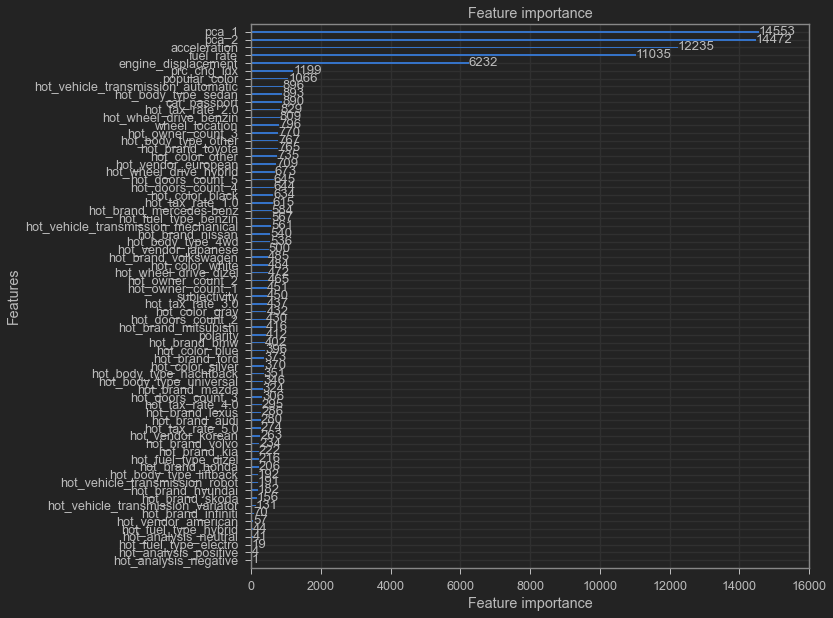

In [96]:
# Check permutation
lightgbm.plot_importance(lgbm, ax=None, height=0.2, xlim=None, ylim=None,
                         title='Feature importance', xlabel='Feature importance', 
                         ylabel='Features', importance_type='split', max_num_features=None,
                         ignore_zero=True, figsize=(10,10), dpi=None, grid=True, precision=3);

# LGBM Optuna

In [120]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
        'metric': 'rmse', 
        'random_state': 42,
        'n_estimators': 500,
        #'n_estimators': trial.suggest_categorical('n_estimators', [50, 100,500,1000]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = lgb.LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [121]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2021-05-27 16:41:09,837] A new study created in memory with name: no-name-babc3a8e-fbc8-4447-9d65-6f38b7e4d56d
[I 2021-05-27 16:41:25,753] Trial 0 finished with value: 0.26969123626264796 and parameters: {'reg_alpha': 0.19953158471347576, 'reg_lambda': 0.010606284033954215, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 404, 'min_child_samples': 14, 'min_data_per_groups': 30}. Best is trial 0 with value: 0.26969123626264796.
[I 2021-05-27 16:41:38,728] Trial 1 finished with value: 0.2620100341106838 and parameters: {'reg_alpha': 9.57643991415038, 'reg_lambda': 0.5287584201533594, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 828, 'min_child_samples': 177, 'min_data_per_groups': 16}. Best is trial 1 with value: 0.2620100341106838.
[I 2021-05-27 16:41:49,192] Trial 2 finished with value: 0.26605960957797836 and parameters: {'reg_alpha': 6.718530907068158, 'reg_lambda': 6.92272514664

[I 2021-05-27 16:48:21,152] Trial 22 finished with value: 0.2534128275848496 and parameters: {'reg_alpha': 0.006365156888040601, 'reg_lambda': 0.24297633879197197, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 694, 'min_child_samples': 132, 'min_data_per_groups': 47}. Best is trial 17 with value: 0.2494786869304806.
[I 2021-05-27 16:48:48,023] Trial 23 finished with value: 0.25107808081387933 and parameters: {'reg_alpha': 0.0018676592313080314, 'reg_lambda': 0.014785741551594686, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 731, 'min_child_samples': 79, 'min_data_per_groups': 83}. Best is trial 17 with value: 0.2494786869304806.
[I 2021-05-27 16:49:13,819] Trial 24 finished with value: 0.24987611390628758 and parameters: {'reg_alpha': 0.008058135457460742, 'reg_lambda': 0.07228995374419613, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.017, 'max_depth': 20, 'num_leav

[I 2021-05-27 16:58:14,532] Trial 44 finished with value: 0.25564786220151475 and parameters: {'reg_alpha': 0.16345195565432494, 'reg_lambda': 0.5399908201180598, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 803, 'min_child_samples': 32, 'min_data_per_groups': 75}. Best is trial 17 with value: 0.2494786869304806.
[I 2021-05-27 16:58:43,784] Trial 45 finished with value: 0.2503742626802775 and parameters: {'reg_alpha': 0.09506105898498353, 'reg_lambda': 0.0014920771402465495, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 721, 'min_child_samples': 1, 'min_data_per_groups': 88}. Best is trial 17 with value: 0.2494786869304806.
[I 2021-05-27 16:59:09,432] Trial 46 finished with value: 0.2653607816731423 and parameters: {'reg_alpha': 0.024875600580855438, 'reg_lambda': 0.0033096455061225535, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 

In [124]:
# plot_optimization_histor: shows the scores from all trials as 
# well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [125]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [126]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''
optuna.visualization.plot_slice(study)

In [130]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

In [131]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

In [123]:
param_lgb = study.best_params

In [132]:
lgb_opt = lgb.LGBMRegressor(**param_lgb)
lgb_opt.fit(X_train, y_train,
         eval_set=[(X_val, y_val)],
         eval_metric='l1',
         early_stopping_rounds=100)


[1]	valid_0's l1: 0.937995	valid_0's l2: 1.34644
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 0.922815	valid_0's l2: 1.30433
[3]	valid_0's l1: 0.90793	valid_0's l2: 1.26359
[4]	valid_0's l1: 0.893308	valid_0's l2: 1.22445
[5]	valid_0's l1: 0.878901	valid_0's l2: 1.18654
[6]	valid_0's l1: 0.864744	valid_0's l2: 1.14981
[7]	valid_0's l1: 0.85082	valid_0's l2: 1.11414
[8]	valid_0's l1: 0.837212	valid_0's l2: 1.07979
[9]	valid_0's l1: 0.823773	valid_0's l2: 1.04663
[10]	valid_0's l1: 0.810613	valid_0's l2: 1.01461
[11]	valid_0's l1: 0.797664	valid_0's l2: 0.983662
[12]	valid_0's l1: 0.784946	valid_0's l2: 0.953624
[13]	valid_0's l1: 0.772443	valid_0's l2: 0.924535
[14]	valid_0's l1: 0.760164	valid_0's l2: 0.89653
[15]	valid_0's l1: 0.74813	valid_0's l2: 0.869324
[16]	valid_0's l1: 0.736274	valid_0's l2: 0.843021
[17]	valid_0's l1: 0.725855	valid_0's l2: 0.820546
[18]	valid_0's l1: 0.714504	valid_0's l2: 0.796067
[19]	valid_0's l1: 0.703237	valid_0's l2: 0

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.017, max_depth=20,
              min_child_samples=36, min_data_per_groups=68, num_leaves=690,
              reg_alpha=0.001083969887511324, reg_lambda=0.15772475792354312,
              subsample=0.4)

In [133]:
lgb_opt_pred = lgb_opt.predict(X_val)

In [134]:
df_report = get_regression_metrics(df_report,y_val,lgb_opt_pred, 'LGB+optuna')
df_report

MAPE            MAE           MSE          RMSE
ExtraTree+baseline        16.485389  133171.400375  1.156922e+11  3.401356e+05
XGBoost_1                 16.267781  133636.793979  1.096894e+11  3.311939e+05
XGBoost_reduced_features  16.321725  134068.711963  1.112268e+11  3.335068e+05
LGB                       16.617327  144602.388101  1.263242e+11  3.554212e+05
Stack                     50.692556  674827.075970  2.645948e+12  1.626637e+06
LGB+optuna                28.326098  396223.085276  1.036164e+12  1.017922e+06

## Gradient boost

In [137]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [138]:
gboost = GradientBoostingRegressor(**params)
gboost.fit(X_train, y_train)
gboost_pred = gboost.predict(X_val)

In [139]:
df_report = get_regression_metrics(df_report,y_val,gboost_pred, 'GBOOST')
df_report

MAPE            MAE           MSE          RMSE
ExtraTree+baseline        16.485389  133171.400375  1.156922e+11  3.401356e+05
XGBoost_1                 16.267781  133636.793979  1.096894e+11  3.311939e+05
XGBoost_reduced_features  16.321725  134068.711963  1.112268e+11  3.335068e+05
LGB                       16.617327  144602.388101  1.263242e+11  3.554212e+05
Stack                     50.692556  674827.075970  2.645948e+12  1.626637e+06
LGB+optuna                28.326098  396223.085276  1.036164e+12  1.017922e+06
GBOOST                    22.255327  250289.029543  4.399267e+11  6.632697e+05

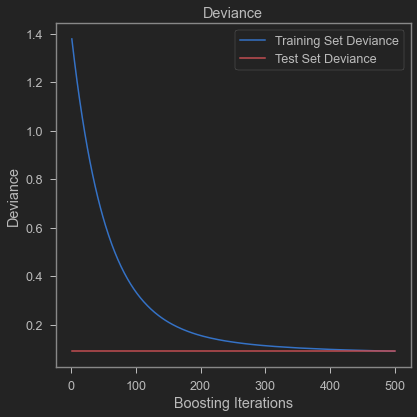

In [140]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(gboost.staged_predict(X_test)):
    test_score[i] = gboost.loss_(y_val, gboost_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gboost.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

## STACKING

In [99]:
from mlxtend.regressor import StackingRegressor

In [103]:
ENet = ElasticNet()

In [104]:
stck_regrs = StackingRegressor(regressors=[rf, xg_reg, lgbm],
                               meta_regressor=ENet)

In [105]:
stck_regrs.fit(X_train,y_train)

[14:46:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




StackingRegressor(meta_regressor=ElasticNet(),
                  regressors=[ExtraTreesRegressor(bootstrap=True,
                                                  n_estimators=300, n_jobs=-1,
                                                  random_state=42),
                              XGBRegressor(alpha=1, base_score=0.5,
                                           booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.5, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.05, max_delta_ste...
                                           reg_alpha=1, reg_lambda=1,
                                           scale_pos_weight=1, silent=1,
                                      

In [106]:
y_pred_stck_regrs = stck_regrs.predict(X_val)

In [107]:
df_report = get_regression_metrics(df_report,y_val,y_pred_stck_regrs, 'Stack')
df_report

MAPE            MAE           MSE          RMSE
ExtraTree+baseline        16.485389  133171.400375  1.156922e+11  3.401356e+05
XGBoost_1                 16.267781  133636.793979  1.096894e+11  3.311939e+05
XGBoost_reduced_features  16.321725  134068.711963  1.112268e+11  3.335068e+05
LGB                       16.617327  144602.388101  1.263242e+11  3.554212e+05
Stack                     50.692556  674827.075970  2.645948e+12  1.626637e+06

In [ ]:
#ensemble = y_pred_stck_regrs*0.70 + xgb_pred*0.1 + lgb_pred*0.1